In [81]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats, linalg
import matplotlib.pyplot as plt
import sympy as sp
import os
import time
import eit
import uuid

In [82]:
from IPython.core.magic import register_cell_magic, needs_local_scope
@needs_local_scope
@register_cell_magic
def capture_cell(line, cell):
    globals()[line.strip()] = cell
    exec(cell, globals())

In [83]:
%%capture_cell params
scale = 1000
stim_current = 1.0

kernel_variance_mult = 100.0
kernel_ls = 0.3007
conductivity_variance_mult = 1.0 # 1e-3 is good
conductivity_ls = 0.3

likelihood_variance = 1.0 # variance for the observation model - based on the value from RA paper

n_radii_forward = 6
n_radii_inverse = 8
bayesian = False
adapt_ls = False

include_prior_mean = False

n_particles = 200
n_iter = 1000
lamb = 100.0 # variance parameter on the temporal prior
tau = 0.0 # shift parameter on the temporal prior
s = 1.0 # interval at which time observations are collected.
beta = 0.05
intermediate_temperatures = 99

n_threads = 7

In [84]:
dest_dir = os.path.join('results', 'temporal_recovery_n={}'.format(n_radii_forward))
if not bayesian:
    dest_dir += '_collocation'
dest_dir += '_' + str(uuid.uuid4())[:8]
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
    os.makedirs(os.path.join(dest_dir, 'detailed_summaries'))
print dest_dir

results/temporal_recovery_n=6_collocation_1ea6e25d


In [85]:
with open(os.path.join(dest_dir, 'params.py'), 'w') as f:
    f.write(params)

In [86]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [87]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tricontourf(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [88]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = scale*stim_pattern*stim_current

In [89]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

In [90]:
pattern = eit.grids.EITPattern(meas_pattern, stim_pattern)

# Load Data

In [91]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

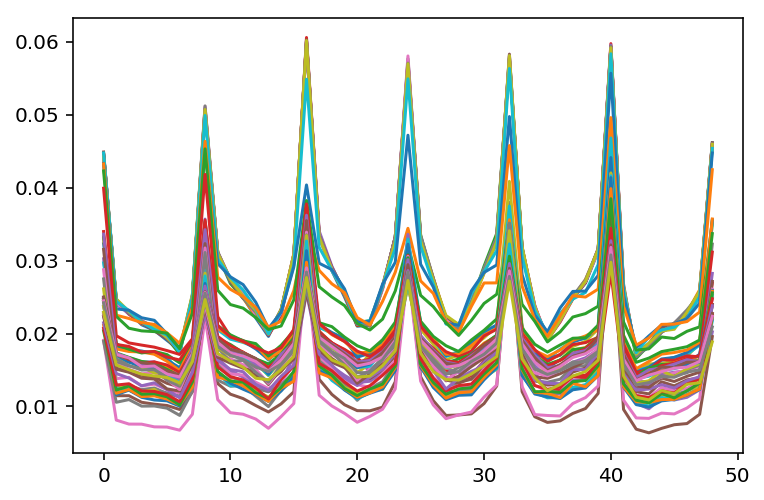

In [92]:
plt.plot(raw_data[:,1:].T);

In [93]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [94]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [95]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

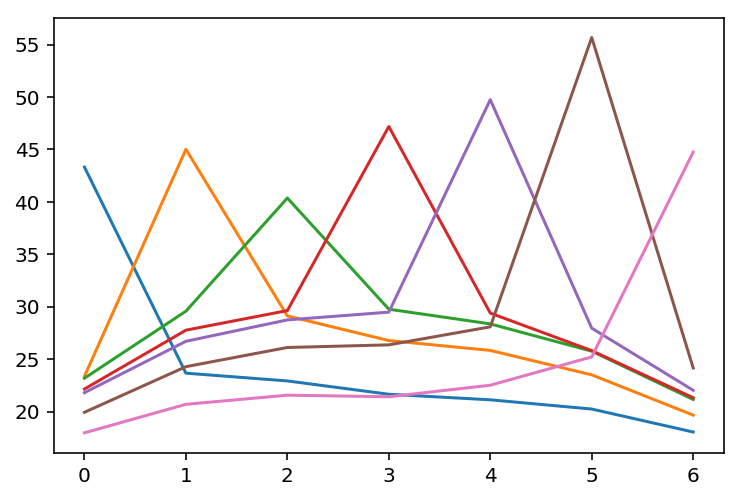

In [96]:
plt.plot(data_dict[11])

# Set Up

In [97]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

## Define the collocation grid

In [98]:
n_in_shell = n_radii_forward
n_bdy = 32
n_sensor = 8
grid = eit.grids.construct_circular(n_in_shell, n_bdy, n_sensor)

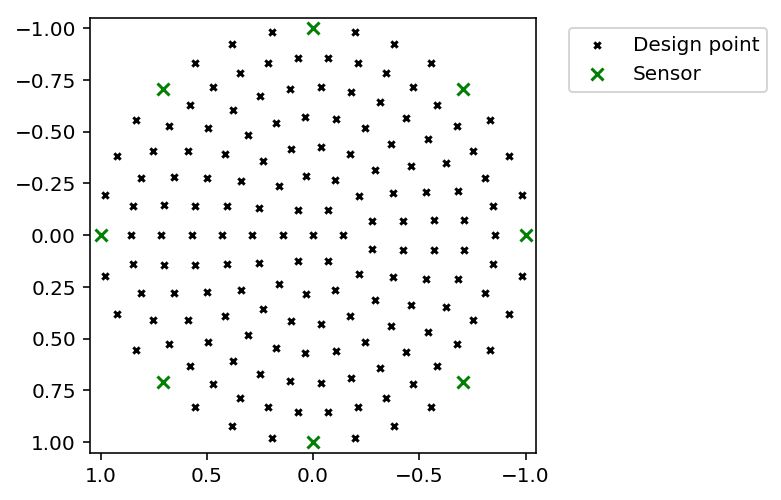

In [99]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=10)
plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(grid.sensors[:,0], grid.sensors[:,1], marker='x', color='green', label='Sensor')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

## Set up Proposal Matrix

In [100]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [101]:
proposal_design = eit.grids.construct_shell(np.linspace(0,1,n_radii_inverse))

(1.05, -1.05)

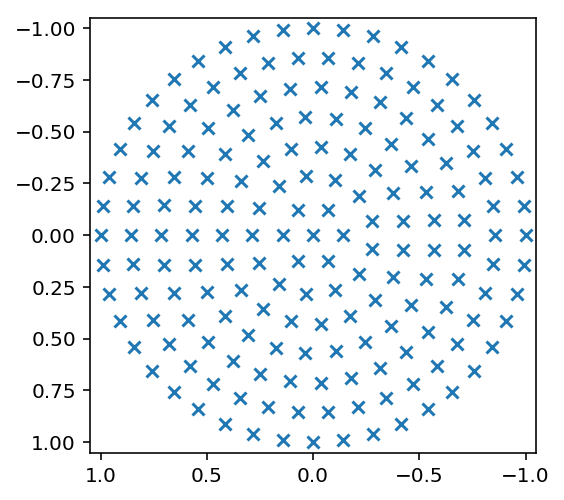

In [102]:

plt.figure(figsize=(4,4))
plt.scatter(proposal_design[:,0], proposal_design[:,1], marker='x')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)

In [103]:
full_design = np.row_stack([grid.interior_plus_boundary, grid.sensors])
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, grid.interior_plus_boundary, grid.interior_plus_boundary],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646662752.2742453

In [104]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)

# Set Up The Potential

In [105]:
# todo: choose this in a more principled way
length_scale = kernel_ls
fun_args = np.array([kernel_ls, kernel_variance_mult])


In [106]:
# choose an initial field
import scipy.optimize
def phi_const(k):
    theta = k*np.ones(proposal_cov.shape[0])
    return eit.pcn_kernel.phi_c(grid, theta, likelihood_variance, pattern, data_dict[11], fun_args, proposal_dot_mat)
    
best_const = scipy.optimize.minimize_scalar(phi_const)

In [107]:
# construct the proposal
beta = 0.05
if include_prior_mean:
    prior_mean = best_const.x*np.ones(proposal_cov.shape[0])
else:
    prior_mean = np.zeros(proposal_cov.shape[0])
sqrt_proposal_cov = np.real_if_close(linalg.sqrtm(proposal_cov))

# Now the SMC

In [108]:
import pandas as pd

In [109]:
# draw the initial sample from the prior
initial_samples = np.random.multivariate_normal(prior_mean, proposal_cov, n_particles)
# seed with kappa_0
#initial_samples = np.repeat(kappa_0[None, :], n_particles, 0)

In [110]:
def smc(initial_samples, kernels, resample_threshold, init_beta, debug=False):
    res_df = pd.DataFrame(columns=('Kernel_Name', 'Beta', 'Accept', 'ESS', 'Time'), index=np.arange(len(kernels)))
    log_weights = 1 - np.log(initial_samples.shape[0])
    weights = 1./initial_samples.shape[0]
    ess = initial_samples.shape[0] # TODO
    cur_sample = initial_samples
    
    samples = []
    beta = init_beta
    for i in xrange(len(kernels)):
        # re-sample
        if ess < resample_threshold*initial_samples.shape[0]:
            if debug: print("Resampling")
            resamp_indices = np.random.choice(len(cur_sample), len(cur_sample), p=weights)
            cur_sample = np.copy(cur_sample[resamp_indices])
            log_weights = np.ones(initial_samples.shape[0]) - np.log(initial_samples.shape[0])
        
        # move
        if debug: print("Evolving particles")
        kernel = kernels[i]
        t = time.time()
        new_sample, average_acceptances, log_likelihoods = kernel.apply(cur_sample, n_iter, n_threads=n_threads, beta=beta, bayesian=bayesian)
        taken = time.time() - t
        log_likelihoods = log_likelihoods.ravel()
        average_acceptances = average_acceptances.ravel()
        if debug: print("Done, it took {:.2f}s".format(taken))
        
        # re-weight
        last_kernel_log_likes = np.nan*np.empty(new_sample.shape[0])
        log_temporal_component = np.empty(new_sample.shape[0])
        for j in xrange(new_sample.shape[0]):
            new_samp = new_sample[j]
            if i > 0:
                last_kernel_log_likes[j] = -kernels[i-1].phi(new_samp, bayesian=bayesian)
            old_samp = cur_sample[j]
            delta = new_samp - old_samp
            log_temporal_component[j] = -1./(2*lamb*(s+tau))*np.dot(delta, np.dot(proposal_cov_inv, delta))

        log_spatial_component = log_likelihoods.ravel()
        if i > 0:
            log_spatial_component = log_spatial_component - last_kernel_log_likes
        
        log_weights = log_weights + log_spatial_component + log_temporal_component
        # log-sum-exp
        norm_factor = np.max(log_weights) + np.log(np.sum(np.exp(log_weights - np.max(log_weights))))
        log_weights = log_weights - norm_factor
        weights = np.exp(log_weights)
        
        output = pd.DataFrame({
            'K_i accept': average_acceptances,
            'K_i log-likelihood': log_likelihoods,
            'K_{i-1} log-likelihood': last_kernel_log_likes,
            'Spatial update': log_spatial_component,
            'Temporal update': log_temporal_component,
            'Log-weights': log_weights,
            'Weights': weights
        })
        output.to_csv(os.path.join(dest_dir, 'detailed_summaries', '{}.csv'.format(kernel.name)))
        if not kernel.tempered:
            plot_circle(proposal_design[:,0], proposal_design[:,1], np.mean(np.exp(cur_sample), axis=0))
            plt.savefig(os.path.join(dest_dir, kernel.name + '.png'))
            plt.close()
        
        if debug: print(log_likelihoods.ravel())
        if debug: print(last_kernel_log_likes)
        if debug: print(log_spatial_component)
        if debug: print(log_temporal_component)
        if debug: print(weights)
        
        ess = np.sum(weights)**2 / np.sum(weights**2)
        if debug: print("iter={} beta={} accept={} ESS={} Time={} name={}".format(i, beta, average_acceptances.mean(), ess, taken, kernel.name))
        
        if average_acceptances.mean() < 0.2:
            beta *= 0.75
        res_df.loc[i] = [kernel.name, beta, average_acceptances.mean(), ess, taken]
        res_df.to_csv(os.path.join(dest_dir, 'summary.csv'))
        cur_sample = new_sample
        samples.append(cur_sample)
    return samples

In [111]:
### create all the kernels
kernels = []
for ix, i_data in enumerate(xrange(11,19)):
    data_prev = np.empty((0,0)) if ix == 0 else data_dict[i_data-1]
    data_next = data_dict[i_data]
    
    
    for j, t in enumerate(np.linspace(0,1,intermediate_temperatures+2)[1:-1]):
        tempered_kernel = eit.pcn_kernel.PCNTemperingKernel_C(
            beta,
            prior_mean,
            sqrt_proposal_cov,
            grid,
            likelihood_variance,
            pattern,
            data_prev,
            data_next,
            t,
            fun_args,
            proposal_dot_mat
        )
        tempered_kernel.name = 'Frame_{}->{}_temp={}'.format(i_data-1, i_data, t)
        tempered_kernel.tempered = True
        kernels.append(tempered_kernel)
    
    pcn_kernel = eit.pcn_kernel.PCNKernel_C(beta, prior_mean, sqrt_proposal_cov, grid, likelihood_variance, pattern, data_next, fun_args, proposal_dot_mat)
    pcn_kernel.name = 'Frame_{}'.format(i_data)
    pcn_kernel.tempered = False
    kernels.append(pcn_kernel)
print len(kernels)

800


In [112]:
results = smc(initial_samples, kernels, 0.5, 0.2, False)

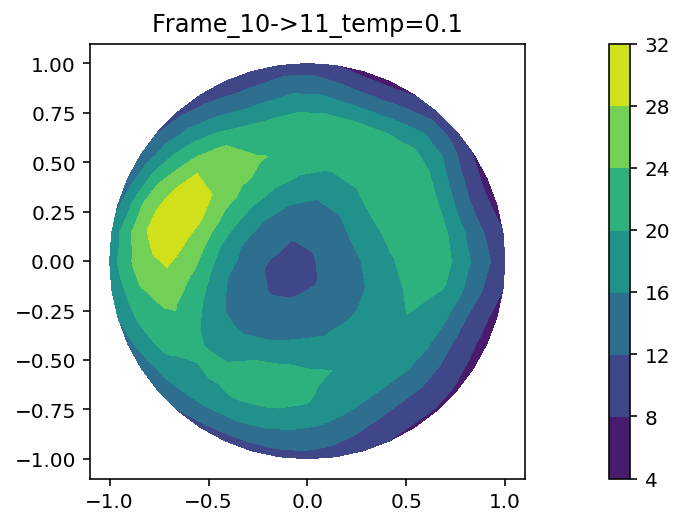

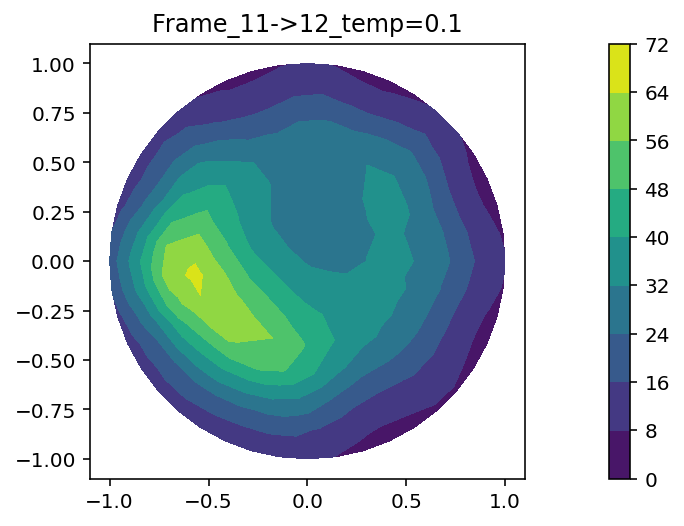

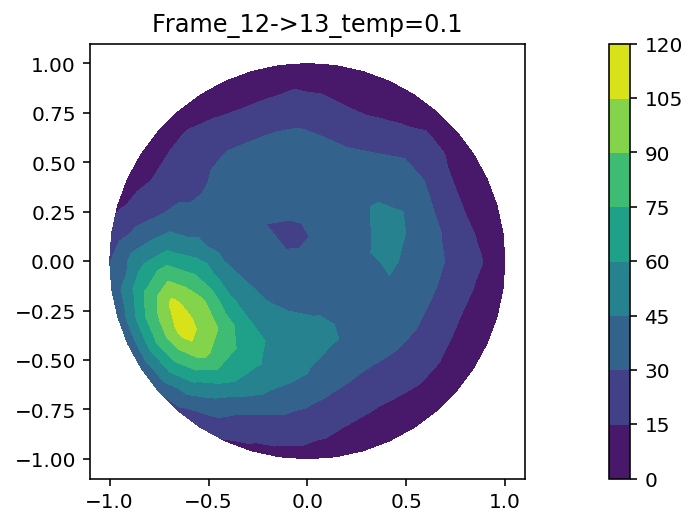

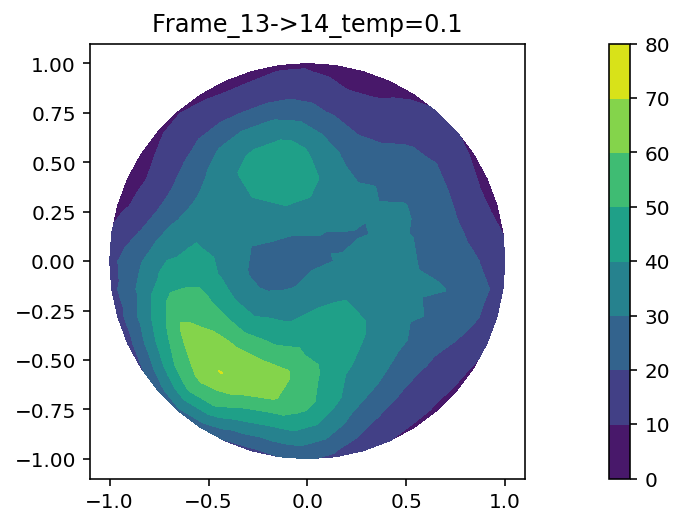

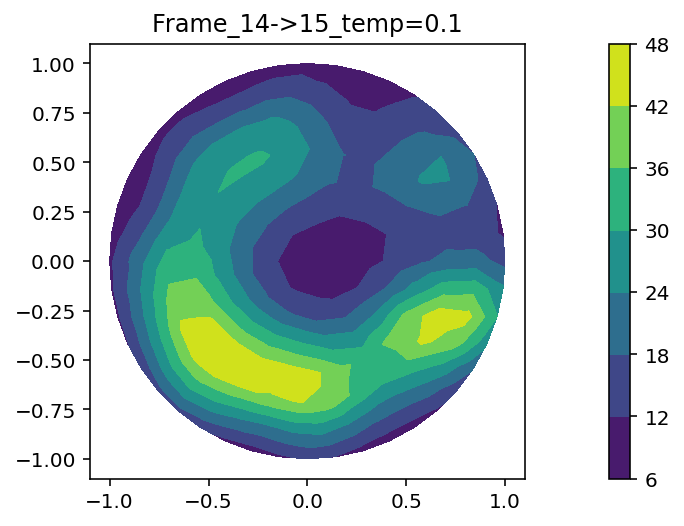

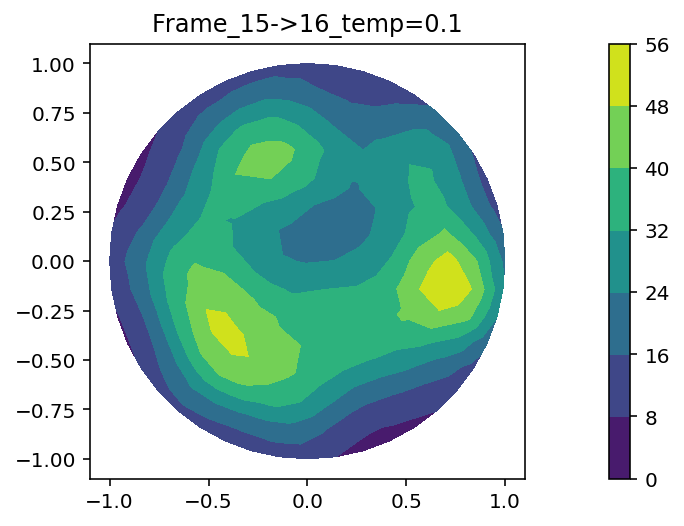

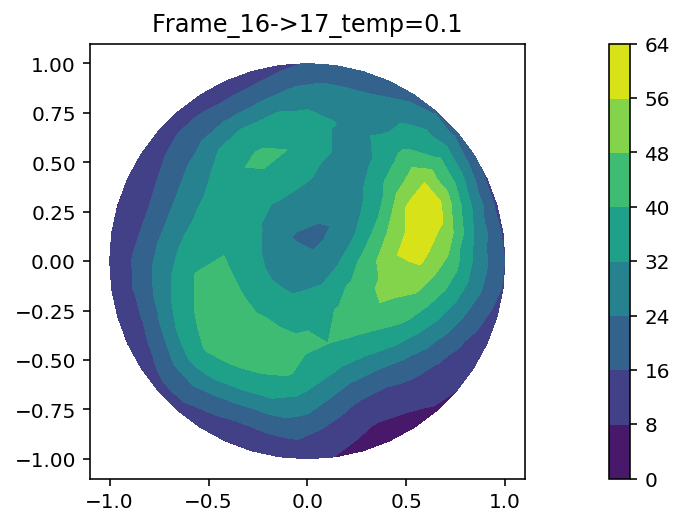

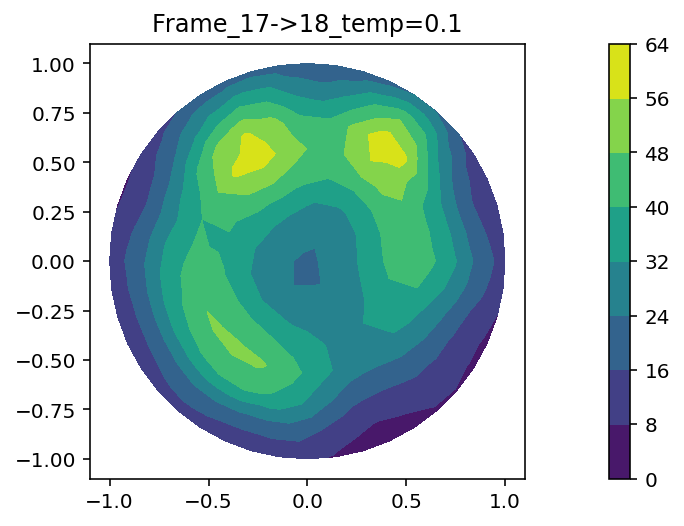

In [113]:
ix=2
for i in xrange(9, len(results), 100):
    plt.figure()
    plot_circle(proposal_design[:,0], proposal_design[:,1], np.mean(np.exp(results[i]), axis=0))
    plt.title(kernels[i].name)

In [114]:
import pickle
with open(os.path.join(dest_dir, 'results.pkl'), 'wb') as f:
    pickle.dump(results, f)


In [115]:
kernels[9].phi(results[9][0,:])

8.746861387423477

In [116]:
kernels[10].name

'Frame_10->11_temp=0.11'

In [117]:
samples_static = np.load('results/static_recovery_f14_n=4/results.npy')

In [118]:
kernels[39].name

'Frame_10->11_temp=0.4'

In [119]:
kernels[39].phi(samples_static[-1,:])

743.1661645064125

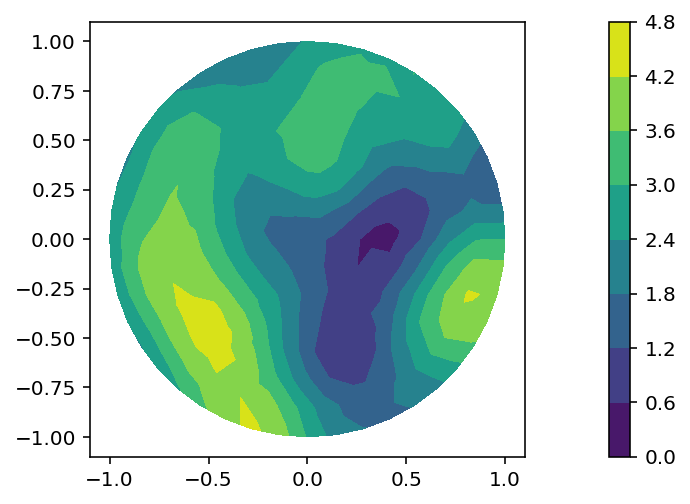

In [120]:
plot_circle(proposal_design[:,0], proposal_design[:,1], samples_static[-2,:])